In [1]:
%matplotlib widget

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

In [2]:
def ratr_contrails(time_horizon, sensitivity_rf_contrails, ratio_erf_rf_contrails, efficacy_erf_contrails):
    ratr = 6.25e14 * sensitivity_rf_contrails * ratio_erf_rf_contrails * efficacy_erf_contrails / time_horizon**0.843
    return ratr

time_horizon = 100
ratio_erf_rf_contrails = 0.42
efficacy_erf_contrails = 1

In [3]:
file_path = 'seg_length_km_GAIA_2019.nc'
dsl = xr.open_dataset(file_path)
print(dsl)

# Somme sur toutes les latitudes et longitudes pour chaque variable souhaitée
sum_seg_length_km = dsl['seg_length_km'].sum(dim=['lat', 'lon']).item()
sum_seg_length_contrail_km = dsl['seg_length_contrail_km'].sum(dim=['lat', 'lon']).item()

print(f"Somme seg_length_km: {sum_seg_length_km}")
print(f"Somme seg_length_contrail_km: {sum_seg_length_contrail_km}")



<xarray.Dataset> Size: 1MB
Dimensions:                 (lat: 180, lon: 360)
Coordinates:
  * lat                     (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                     (lon) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
Data variables:
    seg_length_km           (lat, lon) float64 518kB ...
    seg_length_contrail_km  (lat, lon) float64 518kB ...
Somme seg_length_km: 60929593892.37307
Somme seg_length_contrail_km: 12505560816.768536


In [4]:
file_path = 'EF_and_RF_per_contrail_length_2010_2019.nc'
ds = xr.open_dataset(file_path)
print(ds)

ds['RFD'] = (('year', 'lat', 'lon'), np.full_like(ds['RF_net'], np.nan))  # initialisation (si nécessaire)
ds['RFDc'] = (('year', 'lat', 'lon'), np.full_like(ds['RF_net'], np.nan))  # initialisation (si nécessaire)

for k in range(2010, 2020):
    rf_net_total = (ds['RF_net'].sel(year=k) * ds['areacella']).sum(dim=['lat', 'lon']).item() / ds['areacella'].sum(dim=['lat','lon']) * 1000
    print(rf_net_total)
    new_var_data = ds.sel(year=k)['RF_net'] / dsl['seg_length_km']
    ds['RFD'].loc[dict(year=k)] = new_var_data
    new_var_data2 = ds.sel(year=k)['RF_net'] / dsl['seg_length_contrail_km']
    ds['RFDc'].loc[dict(year=k)] = new_var_data2

<xarray.Dataset> Size: 29MB
Dimensions:       (year: 10, lat: 180, lon: 360)
Coordinates:
  * year          (year) int64 80B 2010 2011 2012 2013 ... 2016 2017 2018 2019
  * lat           (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon           (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    RF_net        (year, lat, lon) float32 3MB ...
    areacella     (lat, lon) float64 518kB ...
    EF            (year, lat, lon) float64 5MB ...
    RF_lin_cotra  (year, lat, lon) float64 5MB ...
    RF_lin        (year, lat, lon) float64 5MB ...
    EF_lin_cotra  (year, lat, lon) float64 5MB ...
    EF_lin        (year, lat, lon) float64 5MB ...
Attributes:
    regrid_method:  conservative
<xarray.DataArray 'areacella' ()> Size: 8B
array(42.99280468)
<xarray.DataArray 'areacella' ()> Size: 8B
array(40.75960847)
<xarray.DataArray 'areacella' ()> Size: 8B
array(43.36802288)
<xarray.DataArray 'areacella' ()> Size: 8B
array(43.62099951)
<xarray.Da

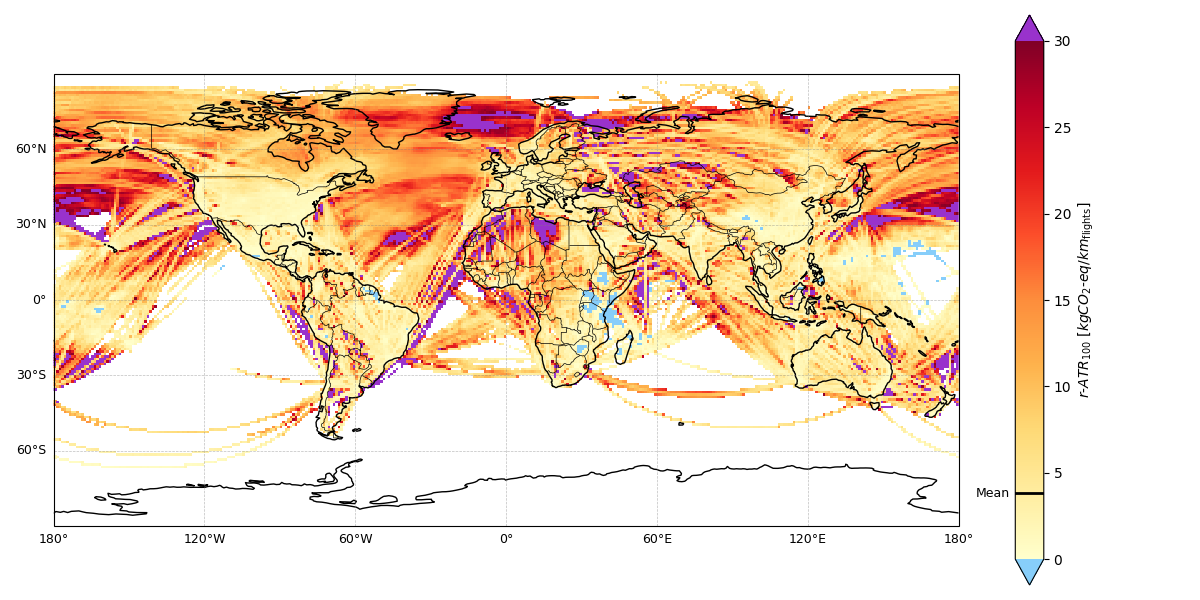

IntSlider(value=2010, description='Année', max=2019, min=2010)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
from IPython.display import display
import numpy as np

output = widgets.Output()
slider = widgets.IntSlider(min=2010, max=2019, step=1, value=2010, description='Year')

# Initialisation figure
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

# Données initiales
year = slider.value
rf_lin_cleaned = ds.sel(year=year)['RFD'].where(np.isfinite(ds.sel(year=year)['RFD']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
data = rf_transformed
atr_i = rf_transformed * dsl['seg_length_km'].where(np.isfinite(dsl['seg_length_km']), np.nan) / sum_seg_length_km
mean_atr = atr_i.sum().item()

Y = 1e4
data_masked = data.where(dsl['seg_length_km'] >= Y)

# Convertir en numpy array (pour manipuler masques, valeurs)
data_np = data_masked.values
# Choix des bornes sur les valeurs positives uniquement
vmin = 0
vmax = 30

# Copier les données pour modifier
plot_data = data_np.copy()

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Colormap avec NaN blanc et valeurs < vmin (négatifs) en noir
cmap = plt.cm.YlOrRd
cmap.set_bad(color=(1,1,1,0))   # NaN en blanc
cmap.set_under('lightskyblue')       # valeurs sous vmin (négatifs) en bleu
cmap.set_over('darkorchid')

pcm = ax.pcolormesh(data['lon'], data['lat'], plot_data,
                    cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

cbar = fig.colorbar(pcm, ax=ax, extend='both')
cbar.set_label(r"$r\text{-}ATR_{100}$ [$kgCO_2\text{-}eq/km_{\text{flights}}$]", fontsize=10)
mean_line = cbar.ax.axhline(mean_atr, color='black', linewidth=2)
mean_text = cbar.ax.text(-0.2, mean_atr, 'Mean', va='center', ha='right', color='black', fontsize=9,
                         transform=cbar.ax.get_yaxis_transform())

fig.tight_layout()
plt.show()

# Fonction d’update sans tout redessiner
def update(change):
    year = change['new']
    rf_lin_cleaned = ds.sel(year=year)['RFD'].where(np.isfinite(ds.sel(year=year)['RFD']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
    rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
    data = rf_transformed
    atr_i = rf_transformed * dsl['seg_length_km'].where(np.isfinite(dsl['seg_length_km']), np.nan) / sum_seg_length_km
    mean_atr = atr_i.sum().item()

    data_masked = data.where(dsl['seg_length_km'] >= Y)

    # Convertir en numpy array (pour manipuler masques, valeurs)
    data_np = data_masked.values

    plot_data = data_np.copy()

    # Mise à jour des données du pcolormesh
    pcm.set_array(plot_data.ravel())
    pcm.set_clim(vmin=vmin, vmax=vmax)

    # Mise à jour ligne + texte "Mean"
    mean_line.set_ydata([mean_atr, mean_atr])
    mean_text.set_position((-0.2, mean_atr))
    
    fig.canvas.draw_idle()

slider.observe(update, names='value')
display(slider)

In [7]:
new_var_data2 = ds['RF_net'] / dsl['seg_length_contrail_km']
ds['RFDc'] = new_var_data2

mean_rfdc = ds['RFDc'].where(np.isfinite(ds['RFDc']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon']) * dsl['seg_length_contrail_km'].where(np.isfinite(dsl['seg_length_contrail_km']), np.nan) / sum_seg_length_contrail_km

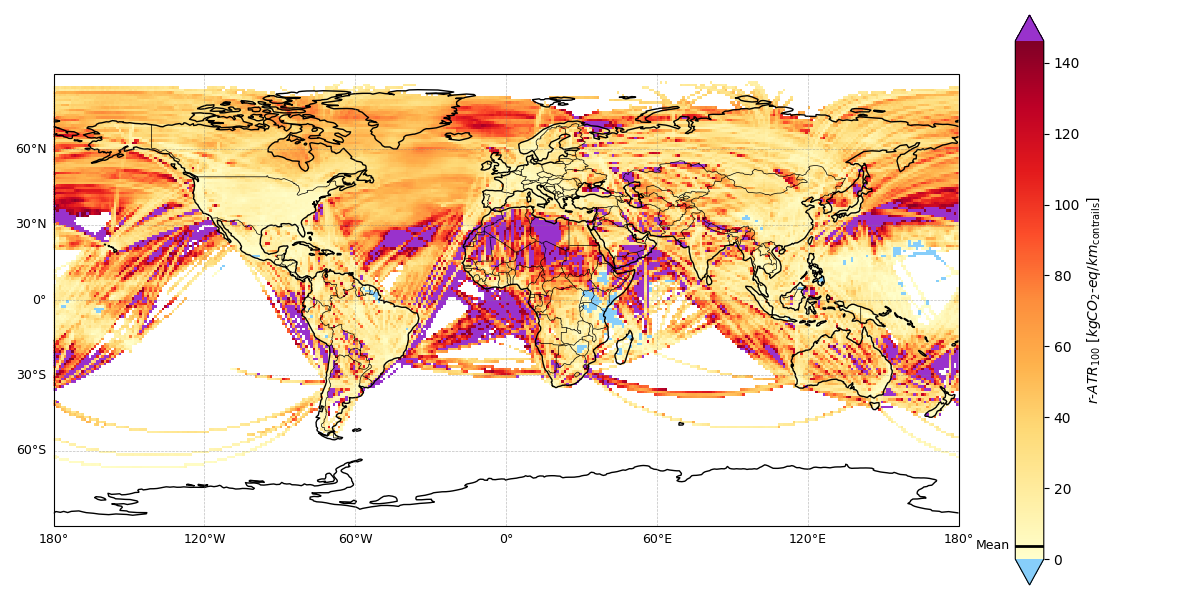

IntSlider(value=2010, description='Year', max=2019, min=2010)

In [10]:
output = widgets.Output()
slider = widgets.IntSlider(min=2010, max=2019, step=1, value=2010, description='Year')

# Initialisation figure
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}

# Données initiales
year = slider.value
rf_lin_cleaned = ds.sel(year=year)['RFDc'].where(np.isfinite(ds.sel(year=year)['RFDc']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
data = rf_transformed

atr_c_i = rf_transformed * dsl['seg_length_contrail_km'].where(np.isfinite(dsl['seg_length_contrail_km']), np.nan) / sum_seg_length_contrail_km
mean_atr_c = atr_c_i.sum().item()

Y = 1e4
data_masked = data.where(dsl['seg_length_km'] >= Y)

# Convertir en numpy array (pour manipuler masques, valeurs)
data_np = data_masked.values
# Choix des bornes sur les valeurs positives uniquement
vmin = 0
vmax = 30 * mean_atr_c/mean_atr

# Copier les données pour modifier
plot_data = data_np.copy()

norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Colormap avec NaN blanc et valeurs < vmin (négatifs) en noir
cmap = plt.cm.YlOrRd
cmap.set_bad(color=(1,1,1,0))   # NaN en blanc
cmap.set_under('lightskyblue')       # valeurs sous vmin (négatifs) en bleu
cmap.set_over('darkorchid')

pcm = ax.pcolormesh(data['lon'], data['lat'], plot_data,
                    cmap=cmap, norm=norm,
                    transform=ccrs.PlateCarree())

cbar = fig.colorbar(pcm, ax=ax, extend='both')
cbar.set_label(r"$r\text{-}ATR_{100}$ [$kgCO_2\text{-}eq/km_{\text{contrails}}$]", fontsize=10)
mean_line = cbar.ax.axhline(mean_atr, color='black', linewidth=2)
mean_text = cbar.ax.text(-0.2, mean_atr, 'Mean', va='center', ha='right', color='black', fontsize=9,
                         transform=cbar.ax.get_yaxis_transform())

fig.tight_layout()
plt.show()

# Fonction d’update sans tout redessiner
def update(change):
    year = change['new']
    rf_lin_cleaned = ds.sel(year=year)['RFDc'].where(np.isfinite(ds.sel(year=year)['RFDc']), np.nan) * ds['areacella'] / ds['areacella'].sum(dim=['lat','lon'])
    rf_transformed = ratr_contrails(time_horizon, rf_lin_cleaned, ratio_erf_rf_contrails, efficacy_erf_contrails)
    data = rf_transformed
    atr_i = rf_transformed * dsl['seg_length_km'].where(np.isfinite(dsl['seg_length_km']), np.nan) / sum_seg_length_km
    mean_atr = atr_i.sum().item()

    data_masked = data.where(dsl['seg_length_km'] >= Y)

    # Convertir en numpy array (pour manipuler masques, valeurs)
    data_np = data_masked.values

    plot_data = data_np.copy()

    # Mise à jour des données du pcolormesh
    pcm.set_array(plot_data.ravel())
    pcm.set_clim(vmin=vmin, vmax=vmax)

    # Mise à jour ligne + texte "Mean"
    mean_line.set_ydata([mean_atr, mean_atr])
    mean_text.set_position((-0.2, mean_atr))
    
    fig.canvas.draw_idle()

slider.observe(update, names='value')
display(slider)